In [2]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, models, LoggingHandler, InputExample, losses, evaluation
from sentence_transformers.losses.TripletLoss import TripletDistanceMetric
from sentence_transformers.evaluation import SimilarityFunction
import numpy as np
import random
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

VOC_NAMES = ["Alpha", "Beta", "Delta", "Gamma", "Omicron"]
LOSS_NAME = "TripletLoss"

In [3]:
#word_embedding_model = models.Transformer(model_name_or_path="Rostlab/prot_bert", max_seq_length=1280)
EPOCHS = 30
DO = 0.0
LR = 1e-3
POOLING_MODE = "max"
modules = []



encoder = models.Transformer(model_name_or_path="./mlm_checkpoints/CoV-RoBERTa_2048",
                                          max_seq_length=1280,
                                          tokenizer_name_or_path="tok/")
modules.append(encoder)

pooler = models.Pooling(encoder.get_word_embedding_dimension(),
                        pooling_mode = POOLING_MODE,
                        pooling_mode_cls_token = False,
                        pooling_mode_max_tokens = False,
                        pooling_mode_mean_tokens = False,
                        pooling_mode_mean_sqrt_len_tokens = False,
                        pooling_mode_weightedmean_tokens = False,
                        pooling_mode_lasttoken = False,)
modules.append(pooler)

if DO > 0.0:
    dropout = models.Dropout(DO)
    modules.append(dropout)


model = SentenceTransformer(modules=modules)

Some weights of the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

# Generate Triplets

In [5]:
sequences = []
for voc_name in VOC_NAMES:
    sequences.append(pd.read_csv(f"data/unique_{voc_name}_2k.csv")["sequence"].tolist())

# sequences = [["00" + str(i) for i in range(10, 34)],
#              ["10" + str(i) for i in range(10, 34)],
#              ["20" + str(i) for i in range(10, 34)],
#              ["30" + str(i) for i in range(10, 34)],
#              ["40" + str(i) for i in range(10, 34)]]

examples = []
r = 1
done = False
while not done:
    print("round", r)
    for a_p_list_id in range(len(sequences)):
        n_list_ids = list(range(len(sequences))).copy()
        n_list_ids.remove(a_p_list_id)
        #print("n_list_ids: ", n_list_ids)
        anchor_positive_list = sequences[a_p_list_id]
        anchor_index = random.randint(0, len(anchor_positive_list) - 1)
        anchor = anchor_positive_list[anchor_index]
        anchor_positive_list.pop(anchor_index)
        positive_index = random.randint(0, len(anchor_positive_list) - 1)
        positive = anchor_positive_list[positive_index]
        anchor_positive_list.pop(positive_index)

        for n_list_id in n_list_ids:
            negative_list = sequences[n_list_id]
            negative_index = random.randint(0, len(negative_list) - 1)
            negative = negative_list[negative_index]
            negative_list.pop(negative_index)
            triplet = [anchor, positive, negative]
            examples.append(InputExample(texts=triplet))
            #print(triplet)
        if len(sequences[0]) == 0 or len(sequences[1]) == 0 or len(sequences[2]) == 0 or len(sequences[3]) == 0 or len(sequences[4]) == 0:
            done = True
            break
    r += 1

print("len(examples): ", len(examples))
print("len(sequences[0]): ", len(sequences[0]))
print("len(sequences[1]): ", len(sequences[1]))
print("len(sequences[2]): ", len(sequences[2]))
print("len(sequences[3]): ", len(sequences[3]))
print("len(sequences[4]): ", len(sequences[4]))

round 1
round 2
round 3
round 4
round 5
round 6
round 7
round 8
round 9
round 10
round 11
round 12
round 13
round 14
round 15
round 16
round 17
round 18
round 19
round 20
round 21
round 22
round 23
round 24
round 25
round 26
round 27
round 28
round 29
round 30
round 31
round 32
round 33
round 34
round 35
round 36
round 37
round 38
round 39
round 40
round 41
round 42
round 43
round 44
round 45
round 46
round 47
round 48
round 49
round 50
round 51
round 52
round 53
round 54
round 55
round 56
round 57
round 58
round 59
round 60
round 61
round 62
round 63
round 64
round 65
round 66
round 67
round 68
round 69
round 70
round 71
round 72
round 73
round 74
round 75
round 76
round 77
round 78
round 79
round 80
round 81
round 82
round 83
round 84
round 85
round 86
round 87
round 88
round 89
round 90
round 91
round 92
round 93
round 94
round 95
round 96
round 97
round 98
round 99
round 100
round 101
round 102
round 103
round 104
round 105
round 106
round 107
round 108
round 109
round 110
round 11

In [6]:
# split examples list into train, validation and test sets
random.shuffle(examples)
train_size = int(len(examples) * 0.8)
val_size = int(len(examples) * 0.1)
train_examples = examples[:train_size]
val_examples = examples[train_size:train_size + val_size]
test_examples = examples[train_size + val_size:]

In [7]:
batch_size = 200 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
dev_dataloader = DataLoader(val_examples, shuffle=False, batch_size=batch_size)
test_dataloader = DataLoader(test_examples, shuffle=False, batch_size=batch_size)

In [8]:
train_loss = losses.TripletLoss(model=model, distance_metric=TripletDistanceMetric.EUCLIDEAN, triplet_margin=5)

In [9]:
evaluator = evaluation.TripletEvaluator.from_input_examples(val_examples, main_distance_function=SimilarityFunction.EUCLIDEAN, name='validation')

In [11]:
import os

# Create output directory if needed
output_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}"
checkpoint_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}/checkpoints"
evaluator_dir = f"./{LOSS_NAME}_output_{POOLING_MODE}/eval"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(evaluator_dir):
    os.makedirs(evaluator_dir)

# read loss values from csv:
train_results_file = os.path.join(output_dir, 'eval', 'training_results.csv')
val_results_file = os.path.join(output_dir, 'eval', 'validation_results.csv')

In [9]:
# Check if the file exists before attempting to delete
if os.path.exists(train_results_file):
    try:
        # Attempt to remove the file
        os.remove(train_results_file)
        print(f"File {train_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {train_results_file} does not exist.")

# Check if the file exists before attempting to delete
if os.path.exists(val_results_file):
    try:
        # Attempt to remove the file
        os.remove(val_results_file)
        print(f"File {val_results_file} deleted successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")
else:
    print(f"File {val_results_file} does not exist.")

File ./TripletLoss_output_max/eval/training_results.csv deleted successfully.
File ./TripletLoss_output_max/eval/validation_results.csv deleted successfully.


In [10]:
print(f"DO={DO}   LR={LR}   EPOCHS={EPOCHS}")

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=EPOCHS,
          optimizer_params= {'lr': LR}, # 1e-3 for CoV-RoBERTa, 1e-6 for ProtBERT
          weight_decay=0.1, # 0.1 for CoV-RoBERTa, 0.01 for ProtBERT
          #evaluation_steps=20, # run an evalution in every 10% 
          output_path=output_dir,
          save_best_model=True,
          checkpoint_path=checkpoint_dir,
          checkpoint_save_steps=500,
          checkpoint_save_total_limit=2,
          show_progress_bar=True,
          loss_name=LOSS_NAME)

DO=0.0   LR=0.001   EPOCHS=30


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 0 ---
Train Loss = 5.25   Train Accuracy = 45.80
Valid Loss = 4.90   Valid Accuracy = 52.85


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 1 ---
Train Loss = 4.94   Train Accuracy = 54.96
Valid Loss = 4.55   Valid Accuracy = 56.76


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 2 ---
Train Loss = 3.97   Train Accuracy = 69.47
Valid Loss = 3.93   Valid Accuracy = 64.71


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 3 ---
Train Loss = 2.59   Train Accuracy = 79.39
Valid Loss = 3.00   Valid Accuracy = 74.32


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 4 ---
Train Loss = 1.92   Train Accuracy = 86.26
Valid Loss = 2.26   Valid Accuracy = 81.53


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 5 ---
Train Loss = 1.53   Train Accuracy = 87.02
Valid Loss = 1.67   Valid Accuracy = 86.04


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 6 ---
Train Loss = 0.90   Train Accuracy = 95.42
Valid Loss = 1.28   Valid Accuracy = 88.59


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 7 ---
Train Loss = 0.64   Train Accuracy = 96.18
Valid Loss = 0.97   Valid Accuracy = 91.59


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 8 ---
Train Loss = 0.29   Train Accuracy = 100.00
Valid Loss = 0.84   Valid Accuracy = 92.94


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 9 ---
Train Loss = 0.48   Train Accuracy = 95.42
Valid Loss = 0.69   Valid Accuracy = 93.99


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 10 ---
Train Loss = 0.14   Train Accuracy = 98.47
Valid Loss = 0.63   Valid Accuracy = 94.29


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 11 ---
Train Loss = 0.04   Train Accuracy = 100.00
Valid Loss = 0.55   Valid Accuracy = 96.10


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 12 ---
Train Loss = 0.02   Train Accuracy = 100.00
Valid Loss = 0.55   Valid Accuracy = 95.65


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 13 ---
Train Loss = 0.09   Train Accuracy = 99.24
Valid Loss = 0.59   Valid Accuracy = 95.35


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 14 ---
Train Loss = 0.09   Train Accuracy = 99.24
Valid Loss = 0.47   Valid Accuracy = 96.40


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 15 ---
Train Loss = 0.01   Train Accuracy = 100.00
Valid Loss = 0.34   Valid Accuracy = 97.15


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 16 ---
Train Loss = 0.06   Train Accuracy = 99.24
Valid Loss = 0.35   Valid Accuracy = 97.00


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 17 ---
Train Loss = 0.12   Train Accuracy = 99.24
Valid Loss = 0.38   Valid Accuracy = 97.60


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 18 ---
Train Loss = 0.05   Train Accuracy = 99.24
Valid Loss = 0.38   Valid Accuracy = 97.00


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 19 ---
Train Loss = 0.09   Train Accuracy = 99.24
Valid Loss = 0.39   Valid Accuracy = 96.70


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 20 ---
Train Loss = 0.01   Train Accuracy = 100.00
Valid Loss = 0.36   Valid Accuracy = 97.45


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 21 ---
Train Loss = 0.15   Train Accuracy = 98.47
Valid Loss = 0.46   Valid Accuracy = 96.25


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 22 ---
Train Loss = 0.03   Train Accuracy = 100.00
Valid Loss = 0.38   Valid Accuracy = 96.55


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 23 ---
Train Loss = 0.00   Train Accuracy = 100.00
Valid Loss = 0.41   Valid Accuracy = 96.55


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 24 ---
Train Loss = 0.10   Train Accuracy = 99.24
Valid Loss = 0.45   Valid Accuracy = 96.10


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 25 ---
Train Loss = 0.16   Train Accuracy = 98.47
Valid Loss = 0.34   Valid Accuracy = 97.30


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 26 ---
Train Loss = 0.06   Train Accuracy = 100.00
Valid Loss = 0.31   Valid Accuracy = 97.60


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 27 ---
Train Loss = 0.01   Train Accuracy = 100.00
Valid Loss = 0.32   Valid Accuracy = 97.15


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 28 ---
Train Loss = 0.02   Train Accuracy = 100.00
Valid Loss = 0.29   Valid Accuracy = 97.90


Iteration:   0%|          | 0/27 [00:00<?, ?it/s]

--- Epoch 29 ---
Train Loss = 0.00   Train Accuracy = 100.00
Valid Loss = 0.30   Valid Accuracy = 97.45


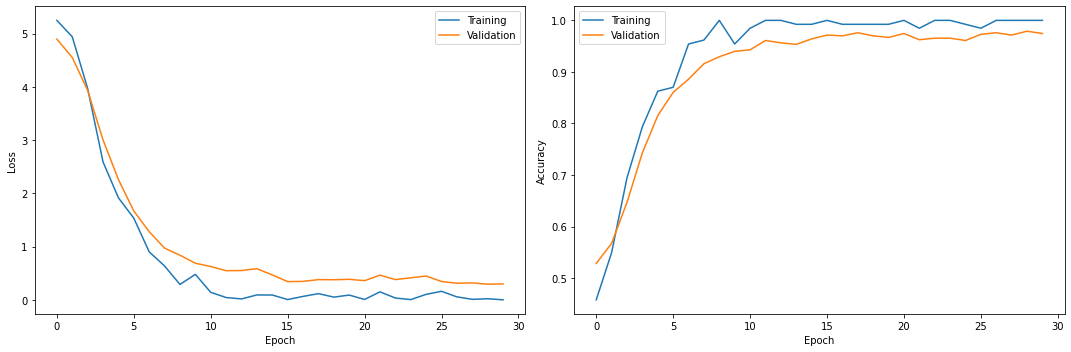

In [11]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

# read loss values from csv:
train_results = pd.read_csv(train_results_file)
val_results = pd.read_csv(val_results_file)

# plot loss and accuracy figures side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_results["epoch"], train_results["loss"], label="Training")
axs[0].plot(val_results["epoch"], val_results["loss"], label="Validation")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(train_results["epoch"], train_results["accuracy_euclidean"], label="Training")
axs[1].plot(val_results["epoch"], val_results["accuracy_euclidean"], label="Validation")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.tight_layout()
#save as pdf
plt.savefig(os.path.join(output_dir, "eval", f'plot_{LOSS_NAME}_{POOLING_MODE}.pdf'))
plt.show()

In [84]:
test_evaluator = evaluation.TripletEvaluator.from_input_examples(test_examples, name='test', batch_size=100)

# load best model
best_model = SentenceTransformer(output_dir)

# print test duration
import time
start_time = time.time()
test_acc = best_model.evaluate(test_evaluator)
duration = time.time() - start_time
print(f"Test duration: {duration} seconds")

# write test accuracy to file
with open(os.path.join(output_dir, "eval", "test_results.txt"), "w") as f:
    f.write(f"Test accuracy: {test_acc}\n")

print(duration * 1000 / len(test_examples), 'ms per example')

Valid Loss = 0.28   Valid Accuracy = 97.45
Test duration: 0.33815932273864746 seconds
0.5069854913622901 ms per example


In [13]:
# Perform zero-shot testing by removing a VOC or adding a new VOI